In [1]:
from sklearn import model_selection, datasets, svm
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt
import time         
from qiskit import *


In [2]:
def feature_map(X):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q,c)
    
    for i,x in enumerate(X):
        qc.rx(x,i)
    return qc,c

def variational_circuit(qc, theta):
    for i in range(N-1):
        qc.cx(i,i+1)
    qc.cx(N-1, 0)
    for i in range(N):
        qc.ry(theta[i],i)
    return qc

def quantum_nn(X,theta,simulator=True):
    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0,c)
    
    shots = 1E4
    backend = Aer.get_backend('qasm_simulator')
    

    
    
    job = qiskit.execute(qc,backend,shots=shots)
    result = job.result()
    counts = result.get_counts(qc) 
    

    return counts['1']/shots

def loss(prediction,target):
    return (prediction-target)**2  

def gradient(X,Y,theta):
    delta = 0.01
    grad = []
    for i in range(len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        pred1 = quantum_nn(X, dtheta)
        pred2 = quantum_nn(X, theta)
        
        grad.append((loss(pred1,Y) - loss(pred2,Y)) / delta)
    return np.array(grad)

def accuracy(X,Y,theta):
    counter = 0
    for X_i,Y_i in zip(X,Y):
        prediction = quantum_nn(X_i, theta)
        if prediction < 0.5 and Y_i == 0:
            counter +=1 
        elif prediction >+= 0.5 and Y_i ==1:
            counter+=1
    return counter/len(Y)

In [3]:
start_time = time.time()

cancer = datasets.load_breast_cancer()
# print(cancer)
X = cancer.data[0:100,:10]
Y = cancer.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,test_size=0.33,random_state=42)
N = 10

In [4]:
eta = 0.05 # 5%
loss_list = []
theta = np.ones(N)

print('EPOCH \t LOSS \t TRAINING ACCURACY')

for i in range(5):
    
    loss_tmp = []
         
    for X_i,Y_i in zip(X_train,Y_train):
        prediction = quantum_nn(X_i,theta)
        loss_tmp.append(loss(prediction, Y_i))
        theta = theta - eta * gradient(X_i,Y_i,theta)
        
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train,Y_train,theta)
    
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

EPOCH 	 LOSS 	 TRAINING ACCURACY
0 	 0.263 	 0.493
1 	 0.259 	 0.493
2 	 0.266 	 0.478
3 	 0.265 	 0.478
4 	 0.279 	 0.493


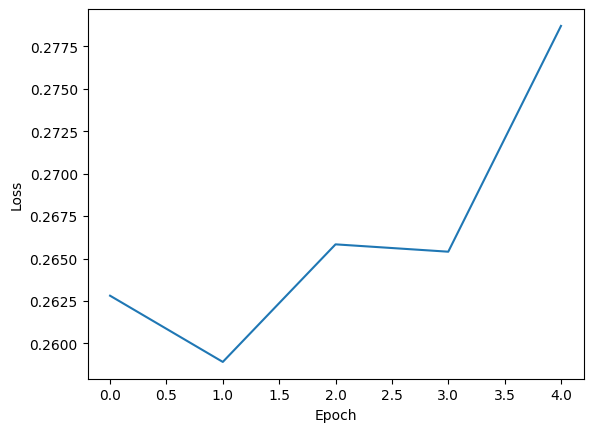

In [7]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

end_time = time.time()


In [8]:
print(f"START:{start_time} \n END:{end_time} \n Total Time:{end_time-start_time}")

START:1711445472.7772818 
 END:1711445904.4882903 
 Total Time:431.7110085487366
